In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

## Data loading and initial exploration

A general overview and description of the dataset variables, basic statistics, missing values, and data types verification.

In [3]:
df_diam = pd.read_csv('diamonds.csv')
df_diam_coord = pd.read_csv('coords_diamonds.csv')
df_diam['latitude']=df_diam_coord['latitude']
df_diam['longitude ']=df_diam_coord['longitude ']
df_diam.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,39.8813889,-83.093056
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,33.4150000,-111.548889
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,40.1672222,-105.101389
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,37.3711111,-85.583056
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,48.5394444,-121.745000


In [4]:
#Set the DataFrame index using and renaming the column 'Unnamed: 0'
df_diam.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df_diam.set_index('id', inplace=True)
df_diam.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
id,,,,,,,,,,,,
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,39.8813889,-83.093056
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,33.4150000,-111.548889
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,40.1672222,-105.101389
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,37.3711111,-85.583056
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,48.5394444,-121.745000


In [5]:
df_diam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53930 entries, 0 to 53929
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   carat       53930 non-null  float64
 1   cut         53930 non-null  object 
 2   color       53930 non-null  object 
 3   clarity     53930 non-null  object 
 4   depth       50968 non-null  float64
 5   table       53930 non-null  float64
 6   price       53930 non-null  int64  
 7   x           52840 non-null  float64
 8   y           53345 non-null  float64
 9   z           53930 non-null  float64
 10  latitude    53930 non-null  object 
 11  longitude   53930 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 5.3+ MB


In [6]:
df_diam.describe()

,carat,depth,table,price,x,y,z,longitude
count,53930.000000,50968.000000,53930.000000,53930.000000,52840.000000,53345.000000,53930.000000,53930.000000
mean,0.797976,61.749425,57.457328,3933.054942,5.730617,5.733112,3.538141,-86.693792
std,0.474035,1.432949,2.234578,3989.628569,1.127572,1.141865,0.708909,39.773132
min,0.200000,43.000000,43.000000,326.000000,-6.370000,-6.610000,-4.060000,-173.985008
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,-112.073333
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,-87.889167
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000,-78.680278
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,178.017649


In [7]:
df_diam.isnull().sum()

carat            0
cut              0
color            0
clarity          0
depth         2962
table            0
price            0
x             1090
y              585
z                0
latitude         0
longitude        0
dtype: int64

In [8]:
df_diam['latitude'] = df_diam['latitude'].str.replace(r'[^0-9.]', '', regex=True)
df_diam['latitude']= pd.to_numeric(df_diam['latitude'], errors='coerce')

## Handling missing data

Just three variables have missing values. In this case, for imputing missing values the distribution of the variable is analyzed: if normally distributed, impute with the mean; otherwise, use the median

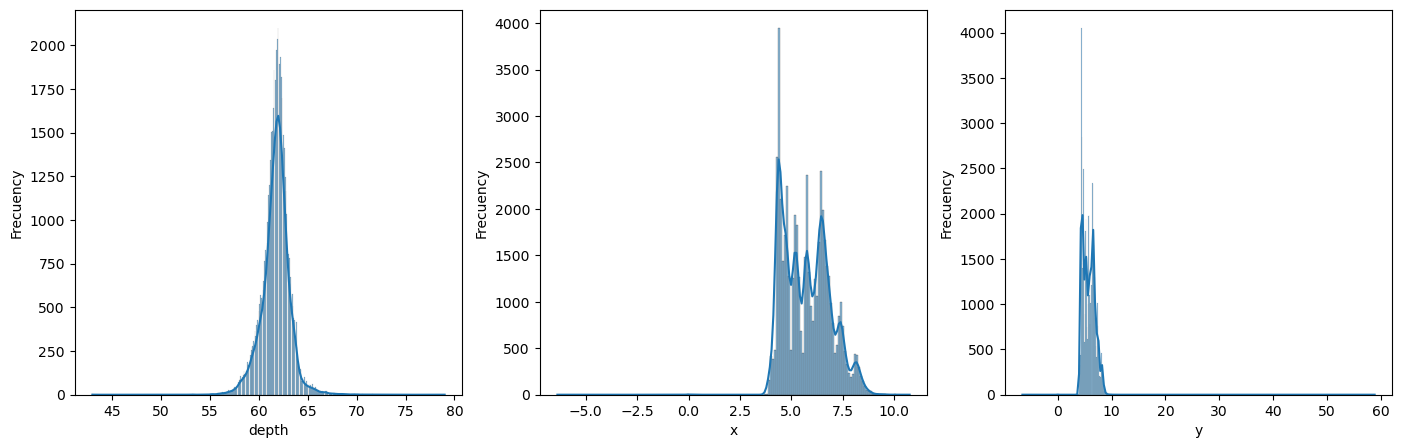

In [9]:
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.histplot(x=df_diam['depth'], kde=True)
plt.xlabel('depth')
plt.ylabel('Frecuency')

plt.subplot(1, 3, 2)
sns.histplot(x=df_diam['x'], kde=True)
plt.xlabel('x')
plt.ylabel('Frecuency')

plt.subplot(1, 3, 3)
sns.histplot(x=df_diam['y'], kde=True)
plt.xlabel('y')
plt.ylabel('Frecuency')
plt.show()

In [10]:
df_diam['depth'].fillna(df_diam['depth'].mean(), inplace=True)
df_diam['x'].fillna(df_diam['x'].median(), inplace=True)
df_diam['y'].fillna(df_diam['y'].median(), inplace=True)

## Exploratory data analysis 

Even though there are several seemingly outlier data points according to the distribution and the boxplot of price, it is not strictly necessary to take action, such as regularizing or standardizing them, because the model to be used (XGBoost) is not sensitive to unregularized data.

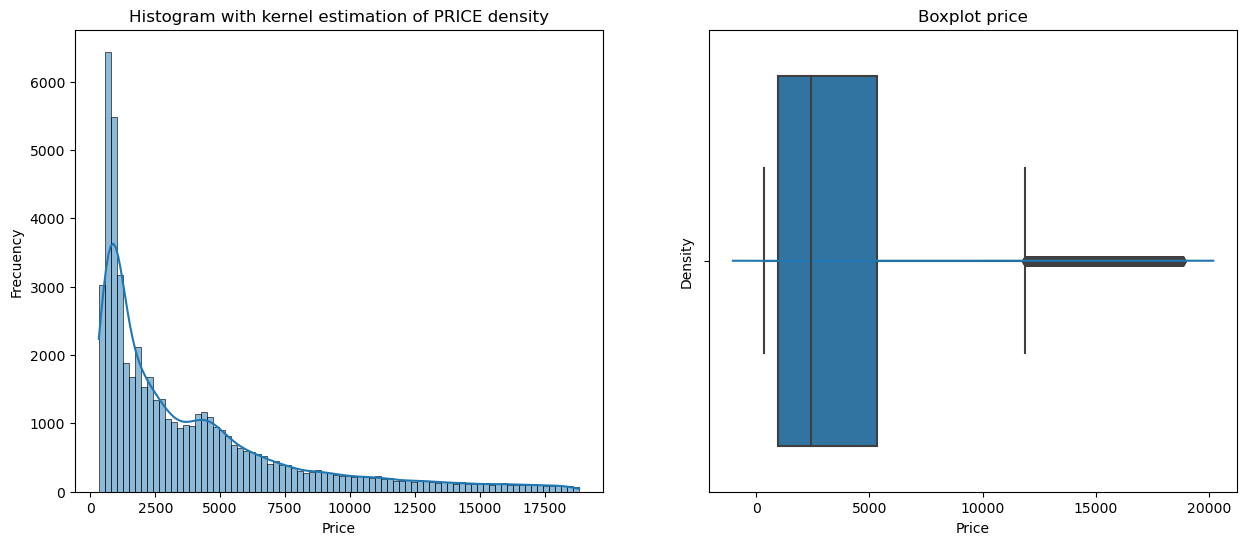

In [11]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(x=df_diam['price'], kde=True)
plt.title('Histogram with kernel estimation of PRICE density')
plt.xlabel('Price')
plt.ylabel('Frecuency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_diam['price'])
plt.title('Boxplot price')
plt.xlabel('Price')
sns.distplot(x = df_diam['price'], kde = True)
plt.show()

The variable price is strongly correlated with Carat and the diamond dimensions (x, y, z), unlike latitude and longitude, whose correlation with these two variables appears to be not very significant.

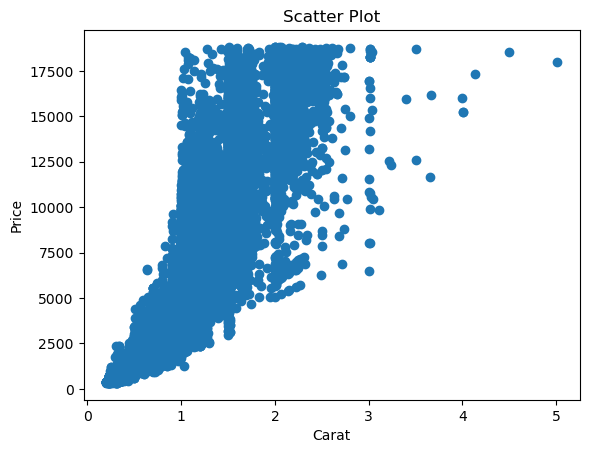

In [12]:
fig, ax = plt.subplots()
ax.scatter(df_diam['carat'], df_diam['price'])
plt.title('Scatter Plot')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.show()

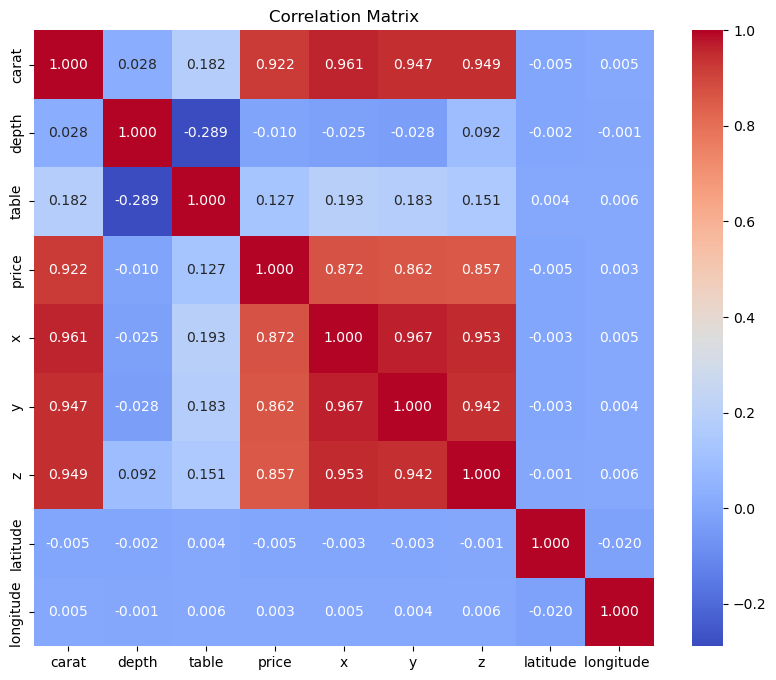

In [13]:
corr_matrix = df_diam.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Correlation Matrix")
plt.show()

## Analysis and cleaning categorical variables 

For the categorical variables first we have to clean and correct the multiple writing errors. Through the clean_special_char function, the special characters will be eliminated, leaving only the alphanumeric ones.

In [14]:
df_diam.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair', 'Very Goo!d',
       "P*'remium", 'I#deal', '#Very Good', 'P?remium', "*'Ideal",
       '!Good', 'Pre!mium', 'Pr?emium', 'Very Go#od', 'Ide&al', 'Ide!al',
       'Id!eal', '&Premium', 'Go?od', 'G#ood', "Very *'Good", "Ide*'al",
       'V&ery Good', '&Ideal', 'Very G#ood'], dtype=object)

In [15]:
df_diam.color.unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D', "*'E", '#F', '&G', '!H', '?J',
       '#D', '&I', '!I', '?G', '#H', '?H', '?E', "*'F", '!E', '&F', '#G',
       "*'I", '!F', '&E'], dtype=object)

In [16]:
df_diam.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF', 'S?I1',
       'SI!1', '&VS2', '&SI2', "S*'I1", 'VS?1', "S*'I2", '#VS1', 'V&S2',
       'V!S2', '!VS2', 'VS#2', "VVS*'2", "*'SI2", 'VV?S1', 'S&I1',
       "*'SI1", 'SI?1', 'VV#S1', 'V#S2', '#SI!1', 'S!I2'], dtype=object)

In [17]:
def clean_special_char(x):
    new_x="".join(filter(str.isalnum, x))
    return new_x

cat_cols = ['cut', 'clarity', 'color']
df_diam[cat_cols] = df_diam[cat_cols].applymap(clean_special_char)

In [18]:
df_diam.cut.unique()

array(['Ideal', 'Premium', 'Good', 'VeryGood', 'Fair'], dtype=object)

The relationship between categorical variables and the variable 'price' is analyzed using ANOVA. P-values from ANOVA indicate that exist a significative relationship between the cut and price as well as between the clarity and price

In [19]:
anova_cut = stats.f_oneway(*(df_diam[df_diam['cut'] == cat]['price'] for cat in df_diam['cut'].unique()))
anova_color = stats.f_oneway(*(df_diam[df_diam['color'] == cat]['price'] for cat in df_diam['color'].unique()))
anova_clarity = stats.f_oneway(*(df_diam[df_diam['clarity'] == cat]['price'] for cat in df_diam['clarity'].unique()))

print('ANOVA cut:', anova_cut)
print('ANOVA color:', anova_color)
print('ANOVA clarity:', anova_clarity)

ANOVA cut: F_onewayResult(statistic=175.89327455026378, pvalue=5.636750960134669e-150)
ANOVA color: F_onewayResult(statistic=290.39243114338154, pvalue=0.0)
ANOVA clarity: F_onewayResult(statistic=215.0312392841735, pvalue=1.84607787e-316)


Categorical variables are manually encoded rather than using LabelEncoder, as they are ordinal variables and it is better to respect the order

In [20]:
cut_encod = {'Fair': 0, 'Good': 1, 'VeryGood': 2, 'Premium': 3, 'Ideal': 4}
df_diam['cut_encoded'] = df_diam['cut'].map(cut_encod)
color_encod = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
df_diam['color_encoded'] = df_diam['color'].map(color_encod)
clarity_encod = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
df_diam['clarity_encoded'] = df_diam['clarity'].map(clarity_encod)
df_diam[['cut_encoded','color_encoded','clarity_encoded']].head()

,cut_encoded,color_encoded,clarity_encoded
id,,,
0,4,5,1
1,3,5,2
2,1,5,4
3,3,1,3
4,1,0,1


## Dataset Splitting and Model Generation

The dataset is split into training and test subsets, and an XGBoost (eXtreme Gradient Boosting) model is generated using default parameters

In [21]:
df_diam.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z', 'latitude', 'longitude ', 'cut_encoded', 'color_encoded',
       'clarity_encoded'],
      dtype='object')

In [22]:
# Using manually encoded variables
X = df_diam.drop(columns=['cut','color', 'clarity', 'price'])
y = df_diam['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

xgb_diam = xgb.XGBRegressor(random_state=42)
xgb_diam.fit(X_train, y_train)
y_pred = xgb_diam.predict(X_test)
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("R2_score: ",r2_score(y_test, y_pred))

Mean Squared Error:  289558.1618063474
R2_score:  0.9813267850445653


Even though the model yields very good results in predictions, RandomizedSearchCV will be used for hyperparameter optimization, aiming to improve accuracy while carefully defining the search space for each parameter to prevent overfitting

In [24]:
from sklearn.model_selection import RandomizedSearchCV
param_list = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha':[1,5,10],
    'reg_lambda':[1,5,10]
    
}

random_search_xgb = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_distributions=param_list,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42
)
random_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", random_search_xgb.best_params_)
print("Best MSE score: ", -random_search_xgb.best_score_)

Best parameters found:  {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best MSE score:  291380.643892919


The chosen model will be xgb_reg, whose parameters were selected through random search, and although the accuracy did not increase significantly, this model is preferred due to its regularization parameters

In [25]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",  
    subsample=0.8,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=1.0,
    reg_lambda = 1, 
    reg_alpha = 5,
    random_state=42
)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print("R2_score: ",r2_score(y_test, y_pred))

Mean Squared Error: 269348.53
R2_score:  0.9826300766454481


In some cases, we have obtained better results by changing the type of encoding for categorical variables. Let's see what happens if we switch to one-hot encoding

In [26]:
df_encoded = pd.get_dummies(df_diam, columns=cat_cols, drop_first=True)
df_encoded.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'latitude',
       'longitude ', 'cut_encoded', 'color_encoded', 'clarity_encoded',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_VeryGood', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2', 'color_E', 'color_F', 'color_G',
       'color_H', 'color_I', 'color_J'],
      dtype='object')

In [27]:
X_new = df_encoded.drop(columns=['cut_encoded','color_encoded', 'clarity_encoded'])
y_new = df_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

In [30]:
from sklearn.model_selection import cross_val_score

xgb_onehot = xgb.XGBRegressor(random_state=42)
xgb_onehot.fit(X_train, y_train)
y_pred = xgb_onehot.predict(X_test)
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))

Mean Squared Error:  70.64358627221014


The MSE decreases dramatically when using one-hot encoding, which can be confirmed by observing the variations in error across the folds of cross-validation. Additionally, it is evident that the average error is significantly higher compared to the error obtained previously, this indicates overfitting, suggesting that this model should not be use

In [31]:
cv_scores = cross_val_score(xgb_onehot, X_new, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores
mean_mse = mse_scores.mean()

print("MSE por cada pliegue:", mse_scores)
print("Mean MSE:", mean_mse)

MSE por cada pliegue: [  311884.95801953  1583810.31410833 10693246.75632303    26586.42256117
   142928.56155239]
Mean MSE: 2551691.4025128894


## Model Visualizations

The following chart shows the importance of the features in the model. The variables that provide the most information for predicting price are carat, the dimensions, and the color of the diamond.

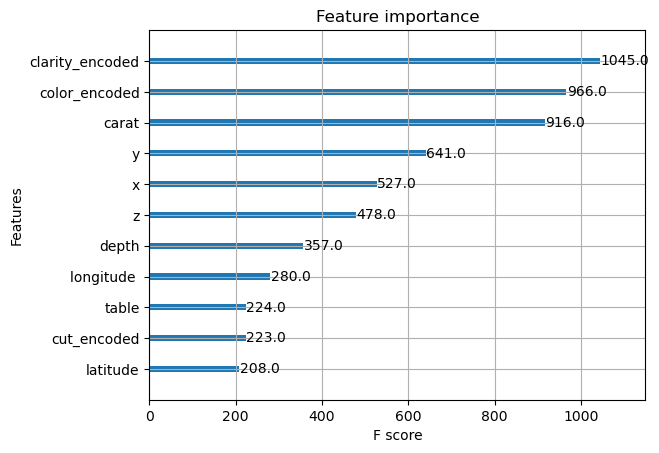

In [32]:
xgb.plot_importance(xgb_reg)
plt.show()

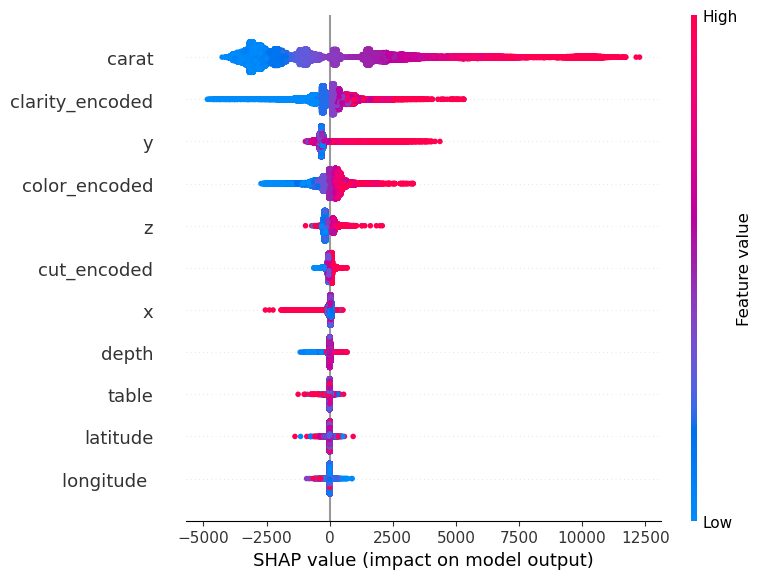

In [33]:
import shap

explainer = shap.Explainer(xgb_diam)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

The following charts show a normal distribution of errors, which means the model is correctly adjusted, and since the residuals are centered around zero, it indicates that the model is not biased.

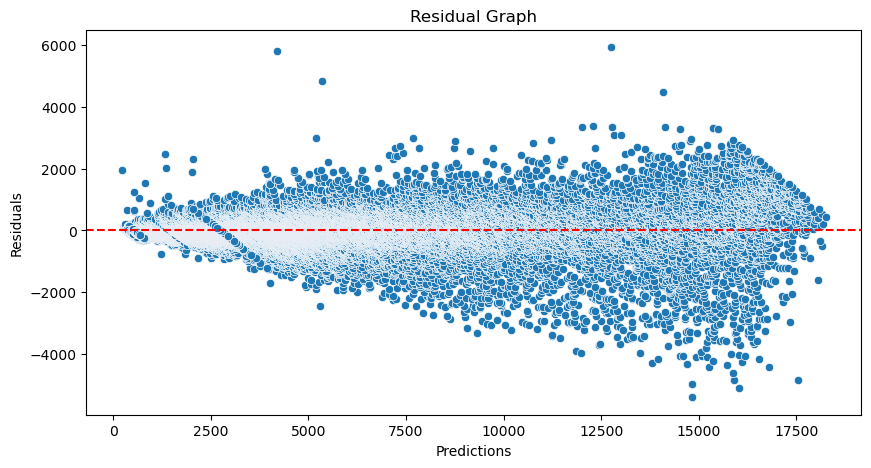

In [34]:
y_pred = xgb_reg.predict(X)
residuals = y - y_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Residual Graph")
plt.show()

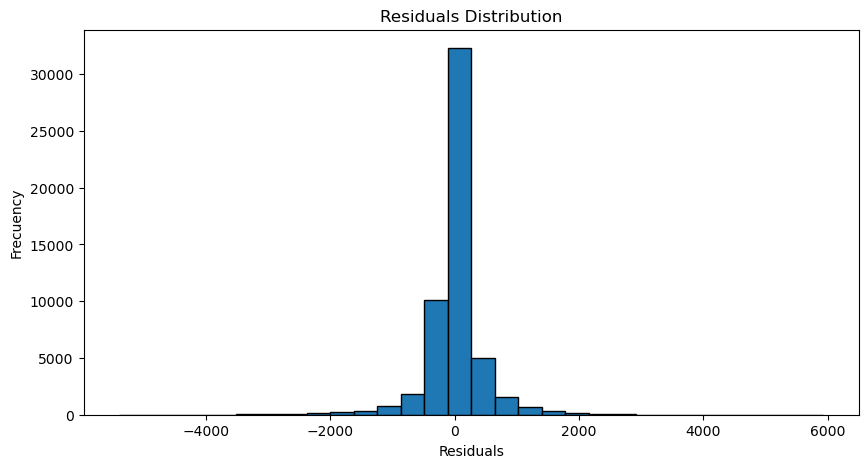

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frecuency")
plt.title("Residuals Distribution")
plt.show()

## Predictions

In [39]:
diam_stolen = pd.read_csv('diams.csv')
diam_stolen.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
diam_stolen.set_index('id', inplace=True)
diam_stolen.head()

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,latitude,longitude
id,,,,,,,,,,,
1,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,35.02636,-114.383510
2,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,35.00350,-109.789610
3,0.50,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,35.10544,-106.669673
4,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,34.94666,-104.647300
5,0.32,Premium,G,VS1,62.1,56.0,4.43,4.40,2.74,35.18864,-101.986020


In [40]:
cut_encod = {'Fair': 0, 'Good': 1, 'VeryGood': 2, 'Premium': 3, 'Ideal': 4}
diam_stolen['cut_encoded'] = diam_stolen['Cut'].map(cut_encod)
color_encod = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
diam_stolen['color_encoded'] = diam_stolen['Color'].map(color_encod)
clarity_encod = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diam_stolen['clarity_encoded'] = diam_stolen['Clarity'].map(clarity_encod)
diam_stolen[['cut_encoded','color_encoded','clarity_encoded']].head()

,cut_encoded,color_encoded,clarity_encoded
id,,,
1,1,1,5
2,4,3,4
3,4,5,3
4,3,0,4
5,3,3,4


In [49]:
diam_stolen.rename(columns={'Carat': 'carat', 'Depth': 'depth', 'Table': 'table'}, inplace=True)


In [51]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'latitude', 'longitude ', 'cut_encoded', 'color_encoded',
           'clarity_encoded']

xgb_reg.save_model("model_xgb.json")
xgb_reg.load_model("model_xgb.json")
diam_stolen['predictions'] = xgb_reg.predict(diam_stolen[features])
tot = diam_stolen['predictions'].sum()
print("Total amount of stolen diamonds:", tot)

Total amount of stolen diamonds: 25039.291


In [52]:
diam_stolen['predictions']

id
1     2431.974121
2     3718.259033
3     1646.418945
4      636.113281
5      748.580750
6     3387.903076
7     1971.346436
8     8859.693359
9     1060.996826
10     578.006348
Name: predictions, dtype: float32